# FD004 - HI_phys_v2 Visualization

Dieses Notebook lädt FD004 Daten, berechnet EGT_Drift, Effizienz_HPC_Proxy, Fan_HPC_Ratio, Twin Residuals und HI_phys_v2
und visualisiert diese über die Cycles für 10 degradierte Engines.


In [50]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from pathlib import Path

# Add project root to path (works in both Jupyter and regular Python)
# In Jupyter, we use the current working directory
if '__file__' in globals():
    # Running as script
    THIS_DIR = os.path.dirname(os.path.abspath(__file__))
    PROJECT_ROOT = os.path.abspath(os.path.join(THIS_DIR, ".."))
else:
    # Running in Jupyter Notebook
    # Assume notebook is in notebooks/ directory, so parent is project root
    PROJECT_ROOT = Path().resolve().parent
    if PROJECT_ROOT.name == "notebooks":
        PROJECT_ROOT = PROJECT_ROOT.parent

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.data_loading import load_cmapps_subset
from src.additional_features import (
    create_physical_features,
    create_twin_features,
    build_condition_features,
    FeatureConfig,
    TemporalFeatureConfig
)
from src.hi_phys_targets import add_hi_phys_v2
from src.config import PhysicsFeatureConfig, ResidualFeatureConfig


## 1. Daten laden und Features erstellen


In [51]:
# 1) FD004 Daten laden
df_train, df_test, y_test = load_cmapps_subset(
    "FD004",
    max_rul=None,
    clip_train=False,
    clip_test=True,
)

print(f"Train data shape: {df_train.shape}")
print(f"Test data shape: {df_test.shape}")
print(f"Number of engines in train: {df_train['UnitNumber'].nunique()}")


[ConditionID] Found 7 unique (S1_r, S2_r, S3_r) combos in TRAIN.
[ConditionID] Train ConditionIDs: [0 1 2 3 4 5 6]
[ConditionID] Test  ConditionIDs: [0 1 2 3 4 5 6]
Train data shape: (61249, 30)
Test data shape: (41214, 27)
Number of engines in train: 249


In [52]:
# 2) Feature-Configs erstellen (wie im Training für ms_dt_v2)
# Physics config (wie in run_experiments.py)
physics_config = PhysicsFeatureConfig(
    use_core=True,
    use_extended=False,
    use_residuals=False,
    use_temporal_on_physics=False,
    residual=ResidualFeatureConfig(enabled=False),
)

# Feature config wird später für create_all_features benötigt (optional für dieses Notebook)
# Wir erstellen es hier, falls wir später temporal features hinzufügen wollen
temporal_cfg = TemporalFeatureConfig(
    base_cols=None,
    short_windows=(5, 10),
    long_windows=(30,),
    add_rolling_mean=True,
    add_rolling_std=False,
    add_trend=True,
    add_delta=True,
    delta_lags=(5, 10),
)
feature_config = FeatureConfig(
    add_physical_core=True,
    add_temporal_features=False,  # Für Visualisierung brauchen wir keine temporal features
    temporal=temporal_cfg,
)

# 3) Physik-Features erstellen (EGT, Druckverhältnis, etc.)
df_train = create_physical_features(
    df_train.copy(),
    physics_config,
    unit_col="UnitNumber",
    cycle_col="TimeInCycles"
)

print("Physical features created.")
print(f"Columns after physics: {len(df_train.columns)}")


Physical features created.
Columns after physics: 34


In [53]:
# 4) Condition Features (für Twin-Modell)
df_train = build_condition_features(
    df_train,
    unit_col="UnitNumber",
    cycle_col="TimeInCycles",
    version=2  # Version 2 für ms_dt_v2
)

print("Condition features created.")
print(f"Columns after condition: {len(df_train.columns)}")


Condition features created.
Columns after condition: 42


In [54]:
# 5) Twin Features + Residuals
df_train, twin_model = create_twin_features(
    df_train,
    unit_col="UnitNumber",
    cycle_col="TimeInCycles",
    baseline_len=30,
    condition_vector_version=2
)

print("Twin features and residuals created.")
print(f"Columns after twin: {len(df_train.columns)}")

# Finde Residual-Spalten
residual_cols = [c for c in df_train.columns if c.startswith("Resid_")]
print(f"Found {len(residual_cols)} residual columns: {residual_cols[:5]}...")


Twin features and residuals created.
Columns after twin: 84
Found 21 residual columns: ['Resid_Sensor1', 'Resid_Sensor2', 'Resid_Sensor3', 'Resid_Sensor4', 'Resid_Sensor5']...


In [55]:
# 6) HI_phys_v2 hinzufügen (zeitaufgelöst pro Engine)
df_train = add_hi_phys_v2(
    df_train,
    unit_col="UnitNumber",
    time_col="TimeInCycles",
    hpc_eff_col="Effizienz_HPC_Proxy",
    egt_drift_col="EGT_Drift",
    residual_prefix="Resid_",
    baseline_len=30,
)

print("HI_phys_v2 created.")
print(df_train[["UnitNumber", "TimeInCycles", "HI_phys_v2"]].head(10))
print(f"\nHI_phys_v2 range: [{df_train['HI_phys_v2'].min():.4f}, {df_train['HI_phys_v2'].max():.4f}]")


HI_phys_v2 created.
   UnitNumber  TimeInCycles  HI_phys_v2
0           1             1    0.919964
1           1             2    0.528042
2           1             3    0.528042
3           1             4    0.528042
4           1             5    0.528042
5           1             6    0.528042
6           1             7    0.490065
7           1             8    0.490065
8           1             9    0.490065
9           1            10    0.490065

HI_phys_v2 range: [0.0000, 0.9902]


## 2. Engines auswählen (10 längste Laufzeiten)


In [56]:
# Engines mit längster Laufzeit auswählen (degradierte Engines)
unit_counts = df_train.groupby("UnitNumber")["TimeInCycles"].max().sort_values(ascending=False)
degraded_units = unit_counts.head(10).index.tolist()

print(f"Selected 10 engines with longest runtime:")
for uid in degraded_units:
    max_cycles = unit_counts[uid]
    print(f"  Engine #{uid}: {max_cycles} cycles")


Selected 10 engines with longest runtime:
  Engine #118: 543 cycles
  Engine #133: 489 cycles
  Engine #173: 457 cycles
  Engine #49: 446 cycles
  Engine #179: 435 cycles
  Engine #225: 418 cycles
  Engine #171: 399 cycles
  Engine #158: 399 cycles
  Engine #37: 388 cycles
  Engine #88: 388 cycles


## 3. Visualisierungen


In [57]:
# Verwende die korrekten physikalischen Feature-Namen aus additional_features.py
# Physics candidates: "Effizienz_HPC_Proxy", "EGT_Drift", "Fan_HPC_Ratio"

# 1. EGT_Drift (Exhaust Gas Temperature Drift)
egt_col = "EGT_Drift" if "EGT_Drift" in df_train.columns else None

# 2. Effizienz_HPC_Proxy (HPC Efficiency Proxy)
efficiency_col = "Effizienz_HPC_Proxy" if "Effizienz_HPC_Proxy" in df_train.columns else None
if not efficiency_col:
    # Fallback: HPC_Eff_Proxy
    efficiency_col = "HPC_Eff_Proxy" if "HPC_Eff_Proxy" in df_train.columns else None

# 3. Fan_HPC_Ratio (Fan to HPC Ratio - Druckverhältnis)
fan_hpc_ratio_col = "Fan_HPC_Ratio" if "Fan_HPC_Ratio" in df_train.columns else None

print(f"EGT_Drift column: {egt_col}")
print(f"Effizienz_HPC_Proxy column: {efficiency_col}")
print(f"Fan_HPC_Ratio column: {fan_hpc_ratio_col}")


EGT_Drift column: EGT_Drift
Effizienz_HPC_Proxy column: Effizienz_HPC_Proxy
Fan_HPC_Ratio column: Fan_HPC_Ratio


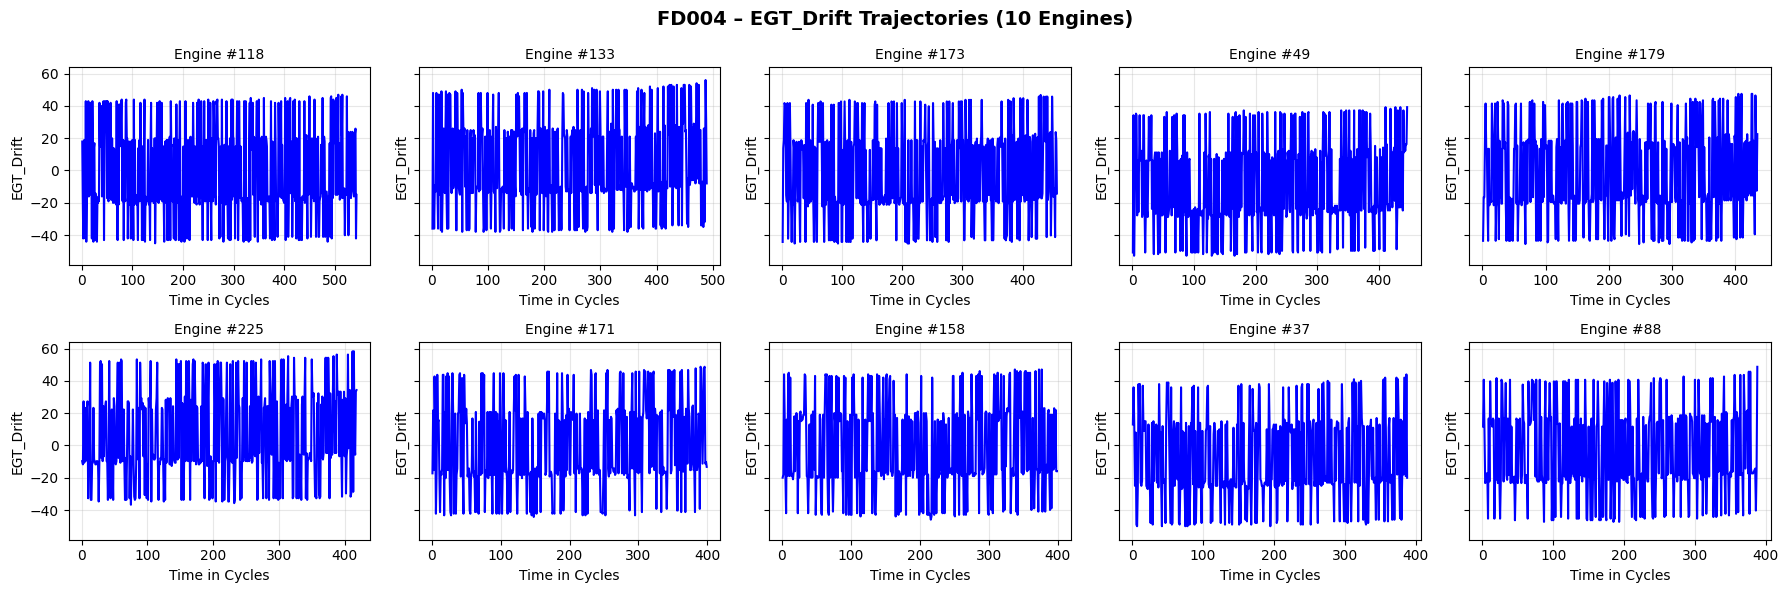

In [58]:
# Plot 1: EGT_Drift über Cycles
if egt_col:
    fig, axes = plt.subplots(2, 5, figsize=(18, 6), sharey=True)
    axes = axes.ravel()

    for ax, uid in zip(axes, degraded_units):
        g = df_train[df_train["UnitNumber"] == uid].sort_values("TimeInCycles")
        
        ax.plot(g["TimeInCycles"], g[egt_col], linewidth=1.5, color='blue')
        ax.set_title(f"Engine #{uid}", fontsize=10)
        ax.set_xlabel("Time in Cycles")
        ax.set_ylabel("EGT_Drift")
        ax.grid(True, alpha=0.3)

    plt.suptitle("FD004 – EGT_Drift Trajectories (10 Engines)", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("EGT_Drift column not found!")


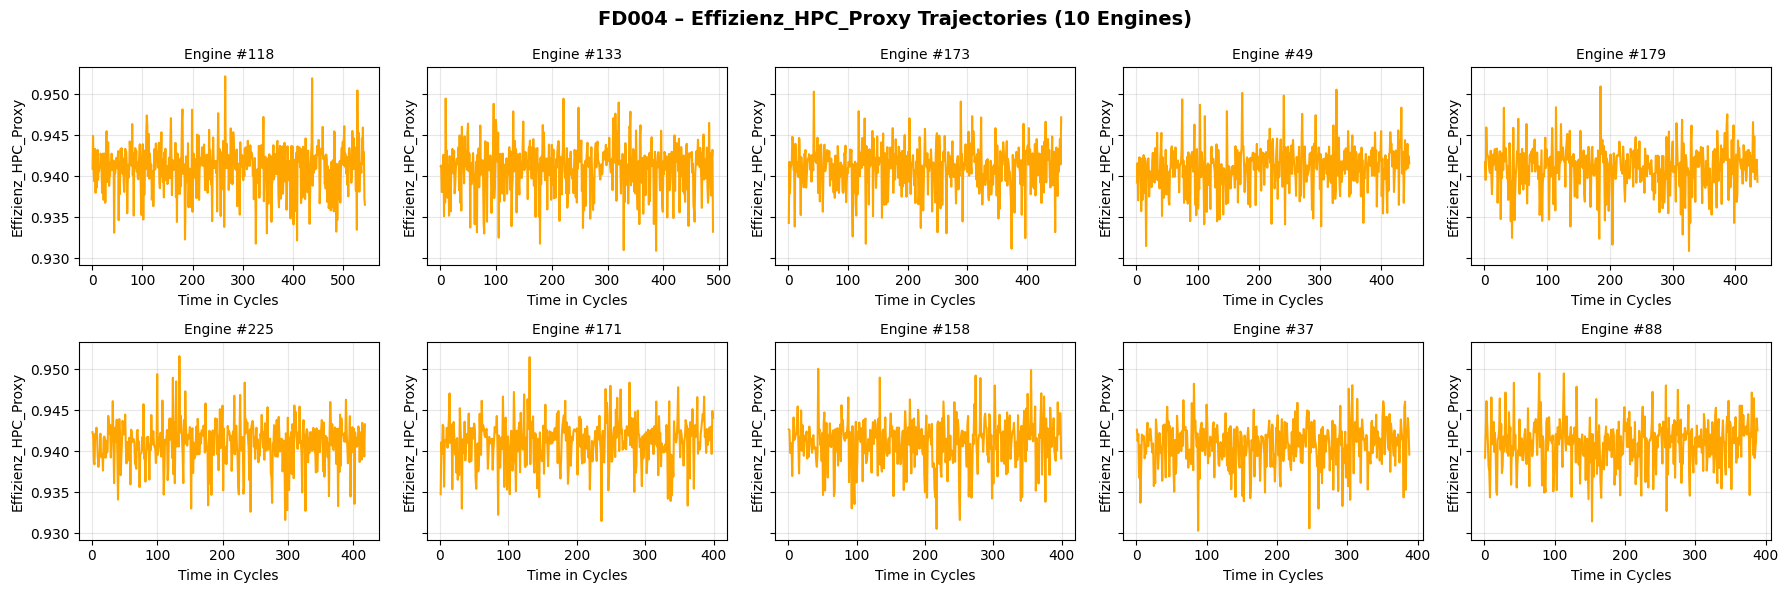

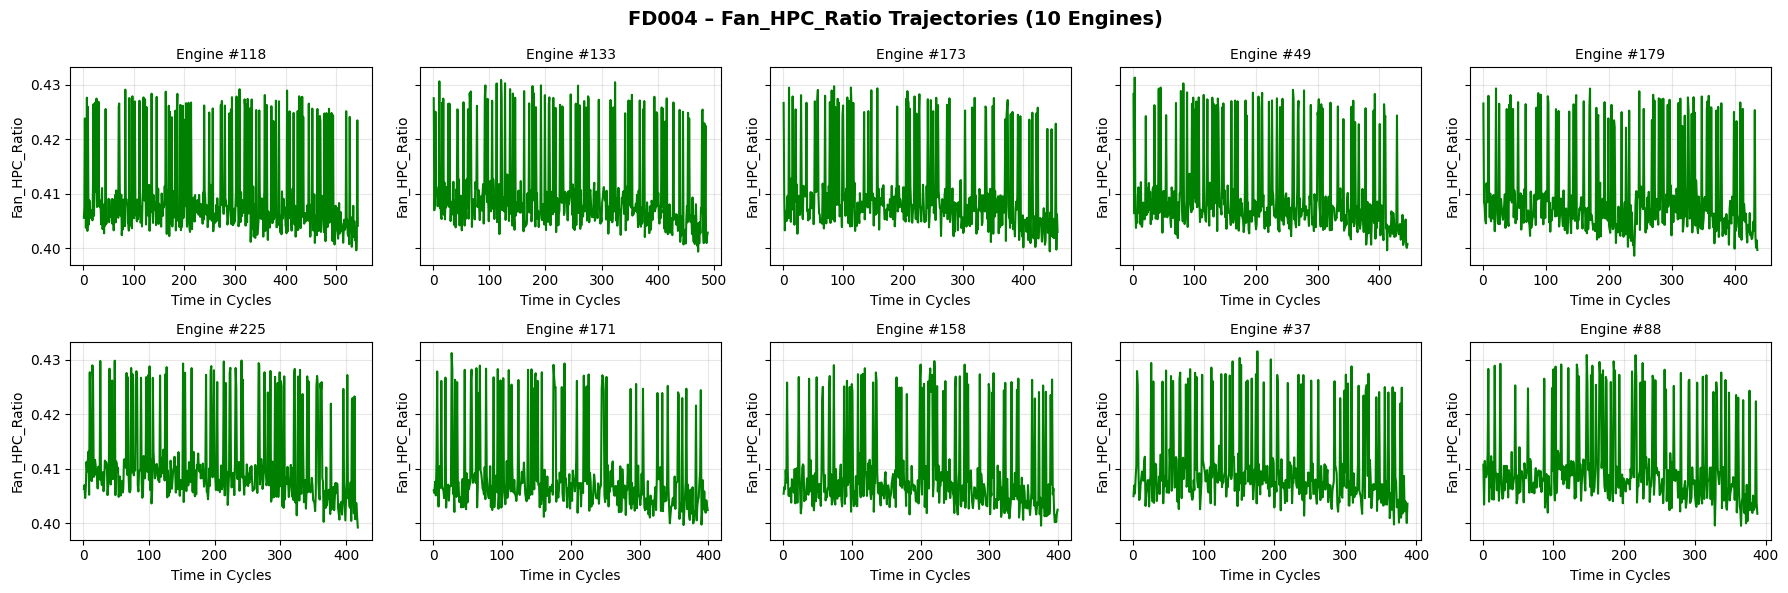

In [59]:
# Plot 2: Effizienz_HPC_Proxy über Cycles
if efficiency_col:
    fig, axes = plt.subplots(2, 5, figsize=(18, 6), sharey=True)
    axes = axes.ravel()

    for ax, uid in zip(axes, degraded_units):
        g = df_train[df_train["UnitNumber"] == uid].sort_values("TimeInCycles")
        
        ax.plot(g["TimeInCycles"], g[efficiency_col], linewidth=1.5, color='orange')
        ax.set_title(f"Engine #{uid}", fontsize=10)
        ax.set_xlabel("Time in Cycles")
        ax.set_ylabel("Effizienz_HPC_Proxy")
        ax.grid(True, alpha=0.3)

    plt.suptitle("FD004 – Effizienz_HPC_Proxy Trajectories (10 Engines)", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("Effizienz_HPC_Proxy column not found!")

# Plot 3: Fan_HPC_Ratio über Cycles
if fan_hpc_ratio_col:
    fig, axes = plt.subplots(2, 5, figsize=(18, 6), sharey=True)
    axes = axes.ravel()

    for ax, uid in zip(axes, degraded_units):
        g = df_train[df_train["UnitNumber"] == uid].sort_values("TimeInCycles")
        
        ax.plot(g["TimeInCycles"], g[fan_hpc_ratio_col], linewidth=1.5, color='green')
        ax.set_title(f"Engine #{uid}", fontsize=10)
        ax.set_xlabel("Time in Cycles")
        ax.set_ylabel("Fan_HPC_Ratio")
        ax.grid(True, alpha=0.3)

    plt.suptitle("FD004 – Fan_HPC_Ratio Trajectories (10 Engines)", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("Fan_HPC_Ratio column not found!")


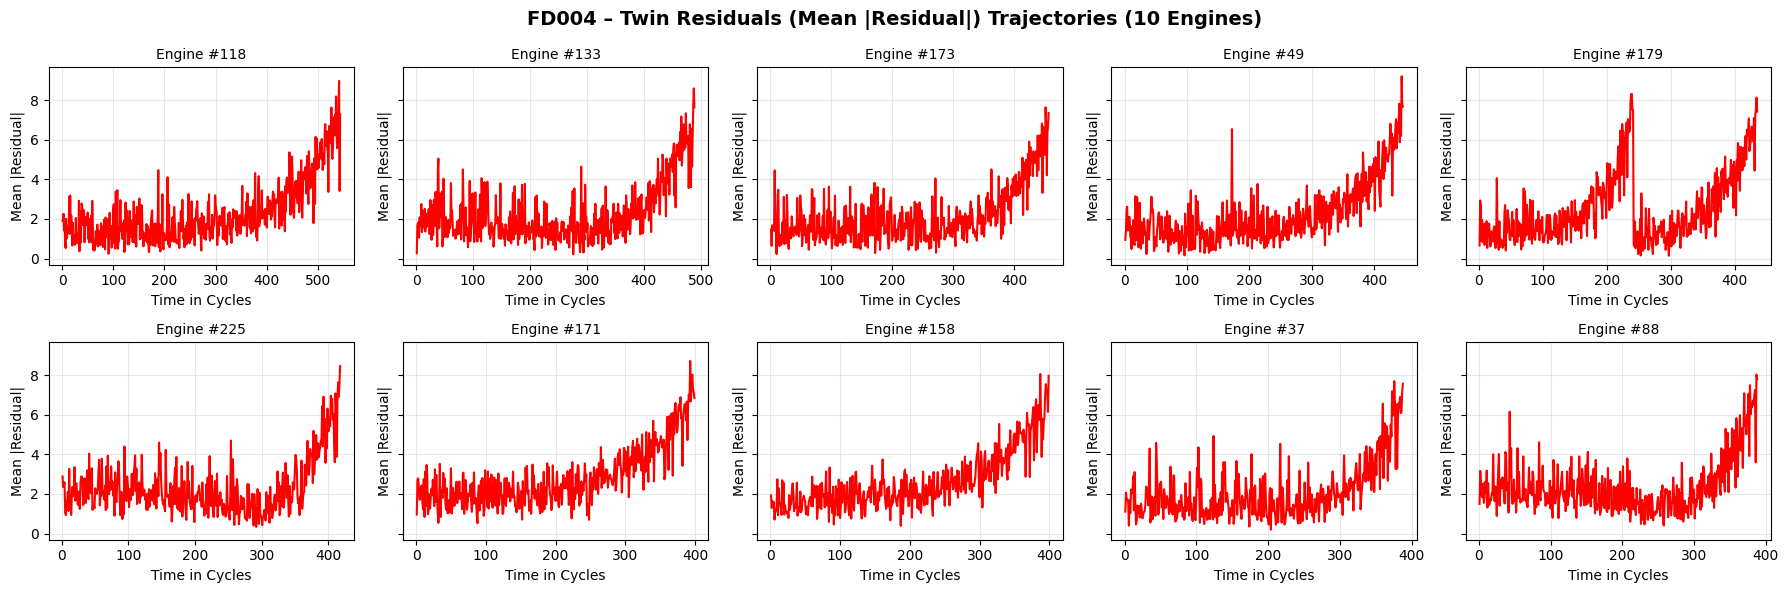

In [60]:
# Plot 4: Twin Residuals über Cycles (Mittelwert aller Residuals)
if residual_cols:
    # Berechne mittleren absoluten Residual pro Zeitschritt
    df_train["Mean_Residual"] = df_train[residual_cols].abs().mean(axis=1)
    
    fig, axes = plt.subplots(2, 5, figsize=(18, 6), sharey=True)
    axes = axes.ravel()

    for ax, uid in zip(axes, degraded_units):
        g = df_train[df_train["UnitNumber"] == uid].sort_values("TimeInCycles")
        
        ax.plot(g["TimeInCycles"], g["Mean_Residual"], linewidth=1.5, color='red')
        ax.set_title(f"Engine #{uid}", fontsize=10)
        ax.set_xlabel("Time in Cycles")
        ax.set_ylabel("Mean |Residual|")
        ax.grid(True, alpha=0.3)

    plt.suptitle("FD004 – Twin Residuals (Mean |Residual|) Trajectories (10 Engines)", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("Residual columns not found!")


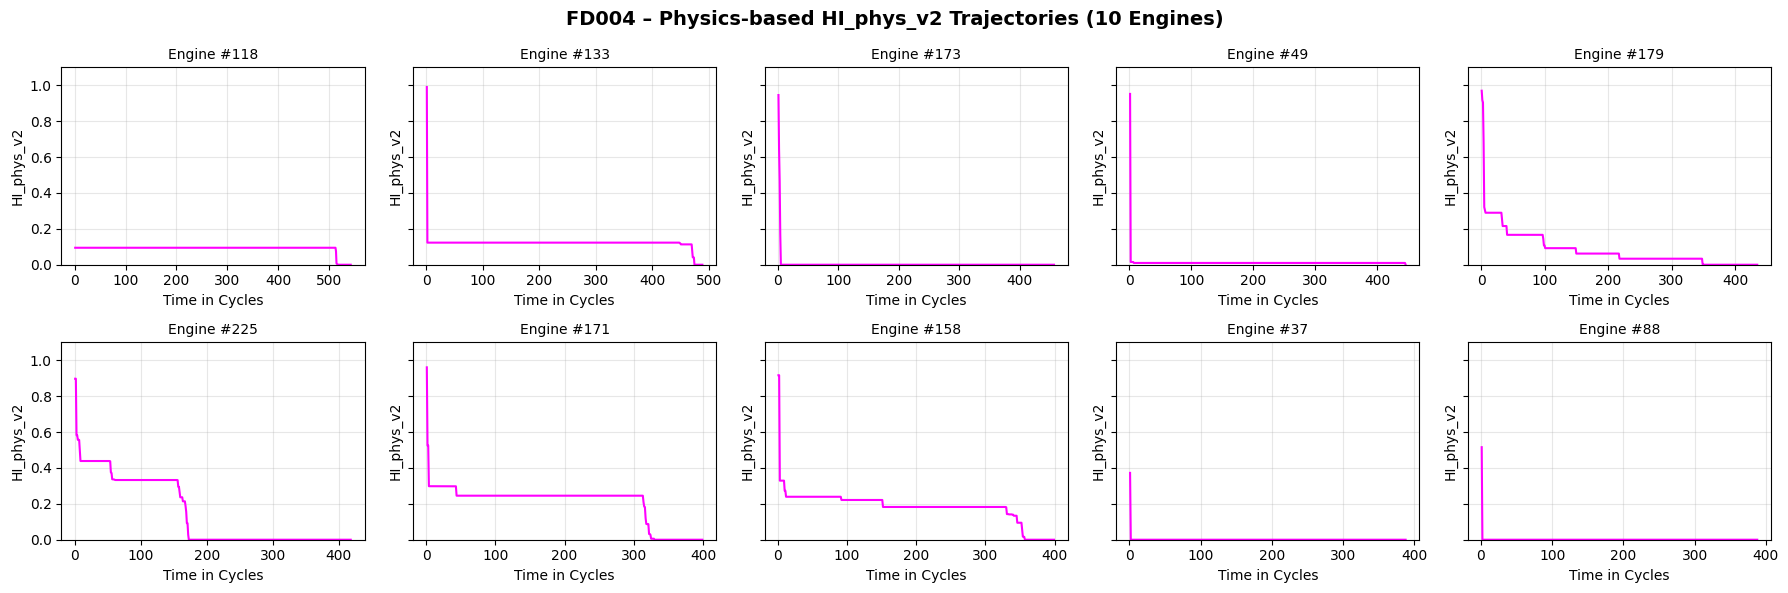

In [61]:
# Plot 5: HI_phys_v2 über Cycles
fig, axes = plt.subplots(2, 5, figsize=(18, 6), sharey=True)
axes = axes.ravel()

for ax, uid in zip(axes, degraded_units):
    g = df_train[df_train["UnitNumber"] == uid].sort_values("TimeInCycles")
    
    ax.plot(g["TimeInCycles"], g["HI_phys_v2"], linewidth=1.5, color='magenta', label="HI_phys_v2")
    ax.set_title(f"Engine #{uid}", fontsize=10)
    ax.set_xlabel("Time in Cycles")
    ax.set_ylabel("HI_phys_v2")
    ax.set_ylim([0, 1.1])
    ax.grid(True, alpha=0.3)

plt.suptitle("FD004 – Physics-based HI_phys_v2 Trajectories (10 Engines)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## 4. Zusammenfassung


In [62]:
# Statistiken für die 10 ausgewählten Engines
print("Summary Statistics for 10 Selected Engines:\n")
print("=" * 60)

for uid in degraded_units:
    g = df_train[df_train["UnitNumber"] == uid].sort_values("TimeInCycles")
    
    print(f"\nEngine #{uid}:")
    print(f"  Total Cycles: {g['TimeInCycles'].max()}")
    if egt_col:
        print(f"  EGT_Drift: [{g[egt_col].min():.2f}, {g[egt_col].max():.2f}] (range)")
    if efficiency_col:
        print(f"  Effizienz_HPC_Proxy: [{g[efficiency_col].min():.4f}, {g[efficiency_col].max():.4f}] (range)")
    if fan_hpc_ratio_col:
        print(f"  Fan_HPC_Ratio: [{g[fan_hpc_ratio_col].min():.4f}, {g[fan_hpc_ratio_col].max():.4f}] (range)")
    if residual_cols:
        mean_resid = g["Mean_Residual"] if "Mean_Residual" in g.columns else g[residual_cols].abs().mean(axis=1)
        print(f"  Mean |Residual|: [{mean_resid.min():.4f}, {mean_resid.max():.4f}] (range)")
    print(f"  HI_phys_v2: [{g['HI_phys_v2'].min():.4f}, {g['HI_phys_v2'].max():.4f}] (range)")
    print(f"  HI_phys_v2 Start: {g['HI_phys_v2'].iloc[0]:.4f}, End: {g['HI_phys_v2'].iloc[-1]:.4f}")


Summary Statistics for 10 Selected Engines:


Engine #118:
  Total Cycles: 543
  EGT_Drift: [-45.10, 46.90] (range)
  Effizienz_HPC_Proxy: [0.9318, 0.9522] (range)
  Fan_HPC_Ratio: [0.3996, 0.4292] (range)
  Mean |Residual|: [0.2381, 8.9624] (range)
  HI_phys_v2: [0.0000, 0.0946] (range)
  HI_phys_v2 Start: 0.0946, End: 0.0000

Engine #133:
  Total Cycles: 489
  EGT_Drift: [-38.00, 56.00] (range)
  Effizienz_HPC_Proxy: [0.9309, 0.9495] (range)
  Fan_HPC_Ratio: [0.3993, 0.4309] (range)
  Mean |Residual|: [0.2155, 8.5852] (range)
  HI_phys_v2: [0.0000, 0.9902] (range)
  HI_phys_v2 Start: 0.9902, End: 0.0000

Engine #173:
  Total Cycles: 457
  EGT_Drift: [-45.25, 46.75] (range)
  Effizienz_HPC_Proxy: [0.9311, 0.9503] (range)
  Fan_HPC_Ratio: [0.3994, 0.4297] (range)
  Mean |Residual|: [0.2285, 7.6301] (range)
  HI_phys_v2: [0.0000, 0.9456] (range)
  HI_phys_v2 Start: 0.9456, End: 0.0000

Engine #49:
  Total Cycles: 446
  EGT_Drift: [-52.80, 39.20] (range)
  Effizienz_HPC_Proxy: [0.9315, 0

## 5. Twin Residual Analysis

Analyse der Twin Residuals: Welche Sensoren treiben die Residual-Damage am stärksten?


In [63]:
# 1) Collect all residual columns
resid_cols = [c for c in df_train.columns if c.startswith("Resid_")]
print(f"Found {len(resid_cols)} residual columns:")
print(resid_cols)

# 2) Helper: compute early/late phase masks per engine
def compute_phase_masks(df_engine: pd.DataFrame, early_frac: float = 0.2, late_frac: float = 0.2):
    """
    Returns boolean masks for early and late phases for a single-engine dataframe
    sorted by TimeInCycles.
    early_frac, late_frac are fractions of the total length.
    """
    g = df_engine.sort_values("TimeInCycles")
    n = len(g)
    n_early = max(1, int(n * early_frac))
    n_late = max(1, int(n * late_frac))
    
    early_mask = np.zeros(n, dtype=bool)
    late_mask = np.zeros(n, dtype=bool)
    early_mask[:n_early] = True
    late_mask[-n_late:] = True
    
    return g, early_mask, late_mask


Found 21 residual columns:
['Resid_Sensor1', 'Resid_Sensor2', 'Resid_Sensor3', 'Resid_Sensor4', 'Resid_Sensor5', 'Resid_Sensor6', 'Resid_Sensor7', 'Resid_Sensor8', 'Resid_Sensor9', 'Resid_Sensor10', 'Resid_Sensor11', 'Resid_Sensor12', 'Resid_Sensor13', 'Resid_Sensor14', 'Resid_Sensor15', 'Resid_Sensor16', 'Resid_Sensor17', 'Resid_Sensor18', 'Resid_Sensor19', 'Resid_Sensor20', 'Resid_Sensor21']


### 5.1 Per-Sensor Residual Trajectories


Example units: [118, 133, 173, 49, 179, 225]
Sensors to plot (first pass): ['Resid_Sensor1', 'Resid_Sensor2', 'Resid_Sensor3', 'Resid_Sensor4', 'Resid_Sensor5', 'Resid_Sensor6']


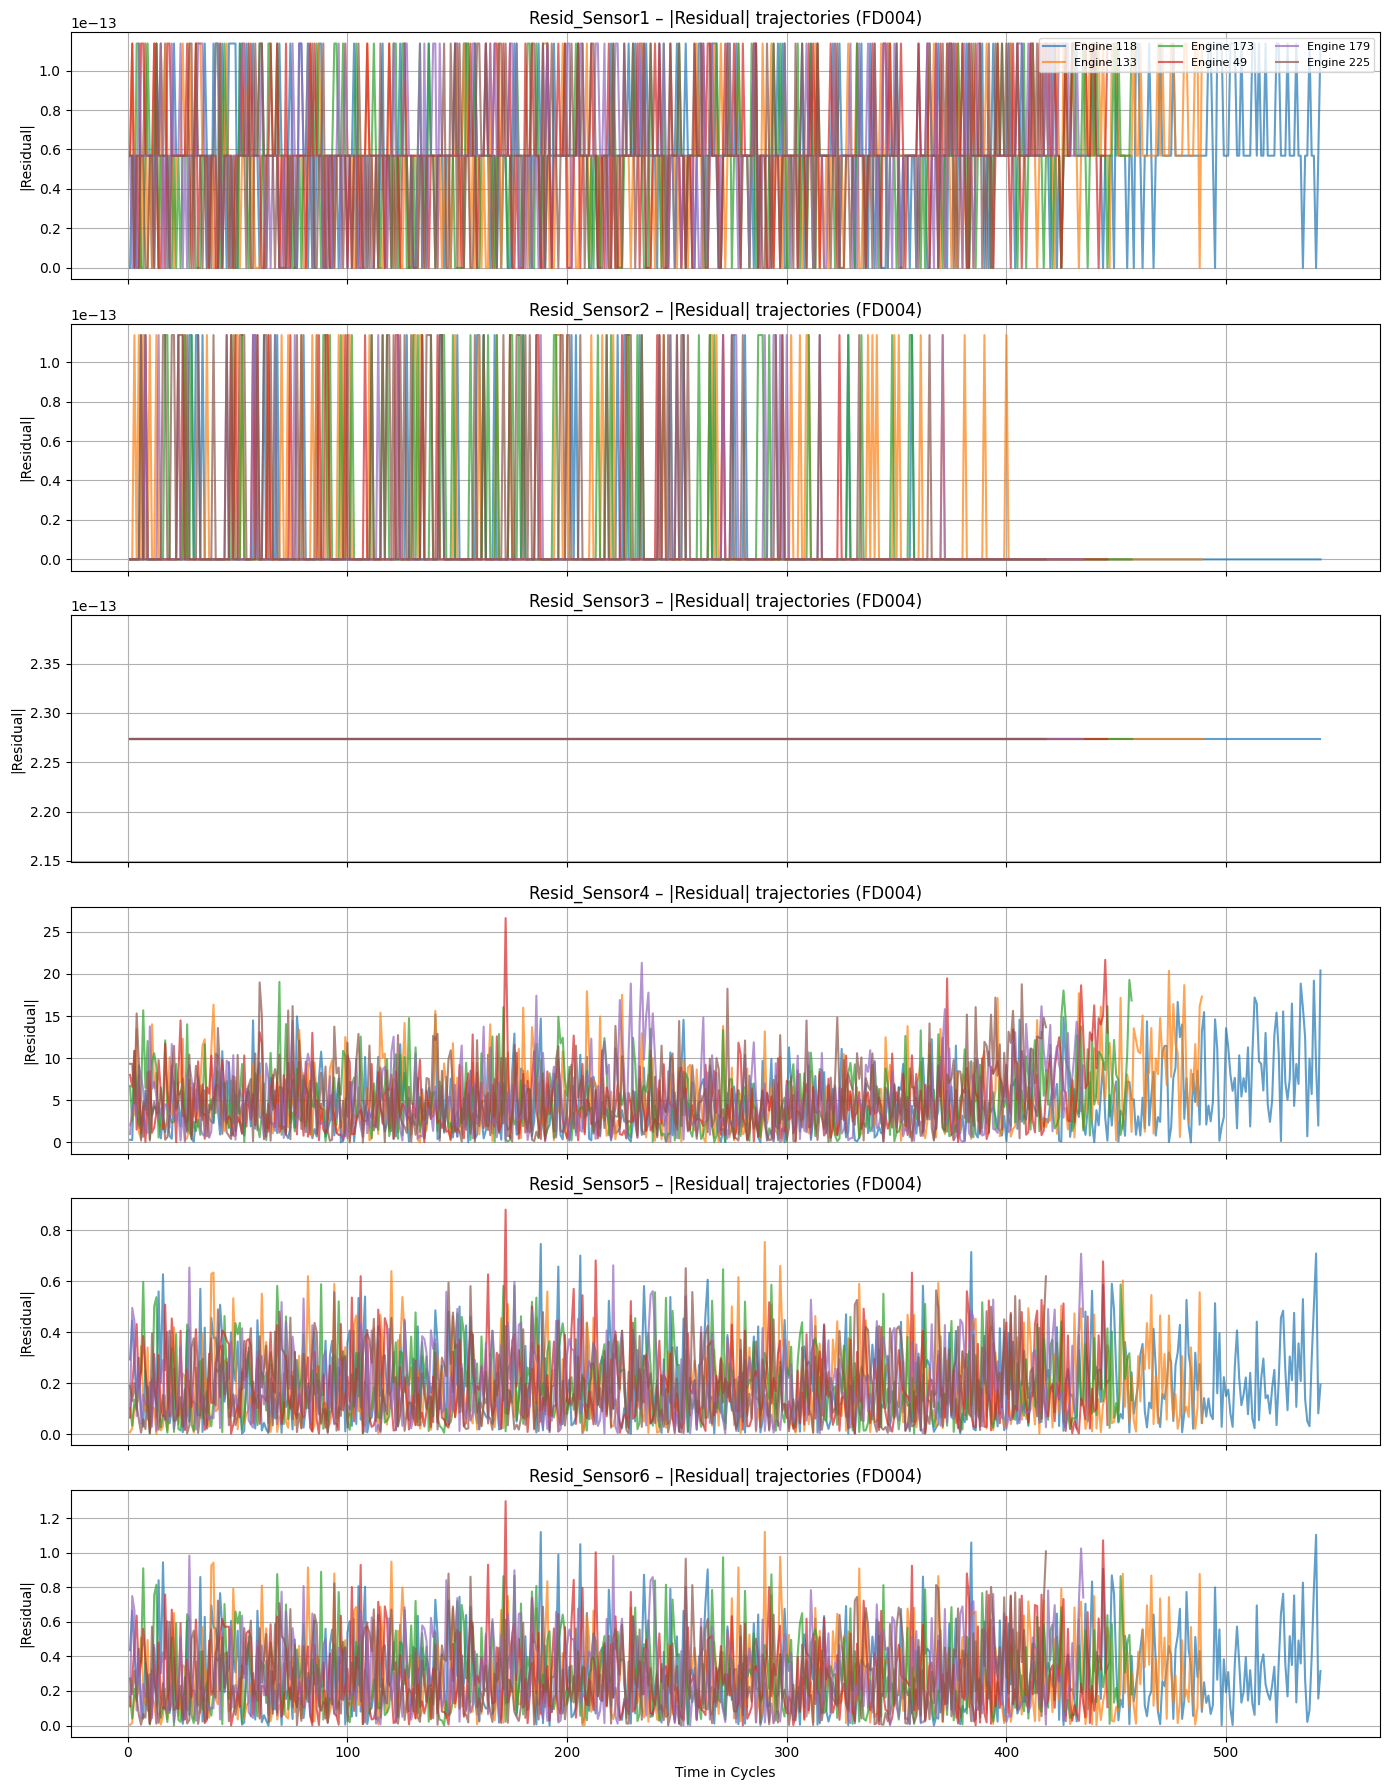

In [64]:
# Choose some example engines – e.g. the 10 with longest life (same as before)
unit_lifetimes = df_train.groupby("UnitNumber")["TimeInCycles"].max().sort_values(ascending=False)
example_units = unit_lifetimes.head(6).index.tolist()   # 6 engines to keep plots readable
print("Example units:", example_units)

# Choose a subset of residual sensors to visualize first
# (we'll rank them later; here we just take all or the first 6 as a start)
max_sensors_to_plot = min(6, len(resid_cols))
sensors_to_plot = resid_cols[:max_sensors_to_plot]
print("Sensors to plot (first pass):", sensors_to_plot)

if len(sensors_to_plot) > 0:
    fig, axes = plt.subplots(len(sensors_to_plot), 1, figsize=(14, 3 * len(sensors_to_plot)), sharex=True)
    
    if len(sensors_to_plot) == 1:
        axes = [axes]
    
    for ax, sensor in zip(axes, sensors_to_plot):
        for uid in example_units:
            g = df_train[df_train["UnitNumber"] == uid].sort_values("TimeInCycles")
            ax.plot(g["TimeInCycles"], np.abs(g[sensor].to_numpy()), label=f"Engine {uid}", alpha=0.7)
        
        ax.set_title(f"{sensor} – |Residual| trajectories (FD004)")
        ax.set_ylabel("|Residual|")
        ax.grid(True)
    
    axes[-1].set_xlabel("Time in Cycles")
    axes[0].legend(loc="upper right", ncol=3, fontsize=8)
    plt.tight_layout()
    plt.show()
else:
    print("No residual columns found!")


### 5.2 Quantitative Ranking: Early vs. Late Residual Level per Sensor


In [65]:
sensor_stats = []

for sensor in resid_cols:
    ratios = []
    deltas = []
    for uid, g in df_train.groupby("UnitNumber"):
        g_sorted, early_mask, late_mask = compute_phase_masks(g)
        
        early_vals = np.abs(g_sorted.loc[early_mask, sensor].to_numpy())
        late_vals  = np.abs(g_sorted.loc[late_mask, sensor].to_numpy())
        
        if early_vals.size == 0 or late_vals.size == 0:
            continue
        
        early_mean = float(early_vals.mean())
        late_mean  = float(late_vals.mean())
        
        # Avoid division by zero
        if early_mean < 1e-6:
            ratio = np.inf
        else:
            ratio = late_mean / early_mean
        
        delta = late_mean - early_mean
        
        ratios.append(ratio)
        deltas.append(delta)
    
    if not ratios:
        continue
    
    sensor_stats.append({
        "sensor": sensor,
        "ratio_late_early_median": float(np.median(ratios)),
        "ratio_late_early_mean": float(np.mean(ratios)),
        "delta_late_early_median": float(np.median(deltas)),
        "delta_late_early_mean": float(np.mean(deltas)),
    })

sensor_stats_df = pd.DataFrame(sensor_stats)

# Rank sensors by median late/early ratio and by median delta
sensor_stats_df_ratio = sensor_stats_df.sort_values("ratio_late_early_median", ascending=False)
sensor_stats_df_delta = sensor_stats_df.sort_values("delta_late_early_median", ascending=False)

print("=== Top sensors by late/early residual RATIO (median over engines) ===")
print(sensor_stats_df_ratio.head(10).to_string())

print("\n=== Top sensors by late-early residual DELTA (median over engines) ===")
print(sensor_stats_df_delta.head(10).to_string())


=== Top sensors by late/early residual RATIO (median over engines) ===
            sensor  ratio_late_early_median  ratio_late_early_mean  delta_late_early_median  delta_late_early_mean
0    Resid_Sensor1                      inf                    inf             1.457524e-14           1.465993e-14
1    Resid_Sensor2                      inf                    inf            -7.195369e-15          -9.692756e-15
2    Resid_Sensor3                      inf                    inf             0.000000e+00          -2.403019e-17
18  Resid_Sensor19                      inf                    inf             8.198570e-16           7.380907e-16
12  Resid_Sensor13                 4.086427               4.763943             2.663729e-01           2.480910e-01
13  Resid_Sensor14                 4.032565               4.985438             2.216764e+01           2.028093e+01
8    Resid_Sensor9                 3.945901               4.775531             2.485549e+01           2.210201e+01
15  Resid

### 5.3 Correlation of Residuals with RUL


In [66]:
# We'll correlate abs residual with -RUL (so that damage ~ larger values)
corr_stats = []

if "RUL" not in df_train.columns:
    print("df_train has no 'RUL' column – skip correlation computation.")
else:
    df_corr = df_train.copy()
    df_corr = df_corr.dropna(subset=["RUL"])
    
    for sensor in resid_cols:
        x = np.abs(df_corr[sensor].to_numpy())
        y = -df_corr["RUL"].to_numpy()  # larger y = closer to EOL
        
        if np.all(np.isfinite(x)) and np.all(np.isfinite(y)):
            if x.std() < 1e-6 or y.std() < 1e-6:
                corr = np.nan
            else:
                corr = np.corrcoef(x, y)[0, 1]
        else:
            corr = np.nan
        
        corr_stats.append({"sensor": sensor, "corr_abs_resid_vs_minusRUL": corr})
    
    corr_df = pd.DataFrame(corr_stats).sort_values("corr_abs_resid_vs_minusRUL", ascending=False)
    print("=== Sensors ranked by correlation(|Resid|, -RUL) ===")
    print(corr_df.head(10).to_string())


=== Sensors ranked by correlation(|Resid|, -RUL) ===
            sensor  corr_abs_resid_vs_minusRUL
14  Resid_Sensor15                    0.470456
13  Resid_Sensor14                    0.461997
8    Resid_Sensor9                    0.458272
12  Resid_Sensor13                    0.421760
10  Resid_Sensor11                    0.346620
3    Resid_Sensor4                    0.297548
7    Resid_Sensor8                    0.244149
16  Resid_Sensor17                    0.244080
15  Resid_Sensor16                    0.179936
9   Resid_Sensor10                    0.135727


### 5.4 Trajectories for Top-N Damage Sensors


Top damage sensors by delta: ['Resid_Sensor9', 'Resid_Sensor14', 'Resid_Sensor4', 'Resid_Sensor7']


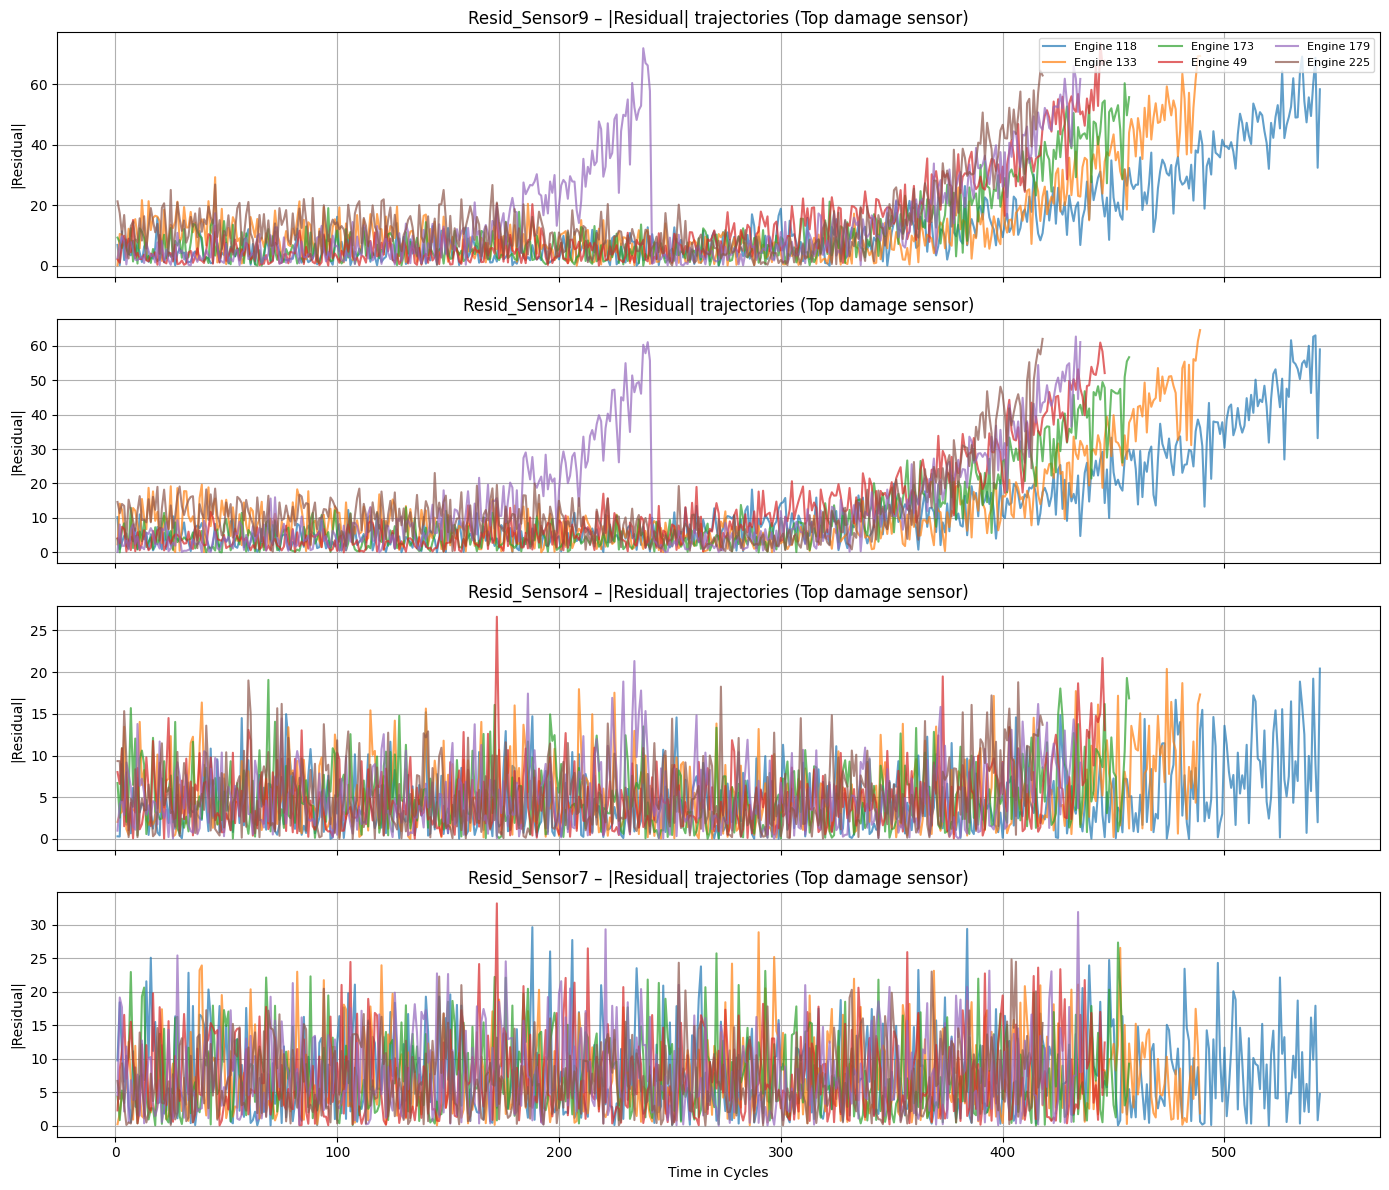

In [67]:
# Choose top 4 sensors by median delta (strong growth over life)
if len(sensor_stats_df_delta) > 0:
    top_sensors = sensor_stats_df_delta.head(4)["sensor"].tolist()
    print("Top damage sensors by delta:", top_sensors)
    
    fig, axes = plt.subplots(len(top_sensors), 1, figsize=(14, 3 * len(top_sensors)), sharex=True)
    
    if len(top_sensors) == 1:
        axes = [axes]
    
    for ax, sensor in zip(axes, top_sensors):
        for uid in example_units:
            g = df_train[df_train["UnitNumber"] == uid].sort_values("TimeInCycles")
            ax.plot(g["TimeInCycles"], np.abs(g[sensor].to_numpy()), label=f"Engine {uid}", alpha=0.7)
        
        ax.set_title(f"{sensor} – |Residual| trajectories (Top damage sensor)")
        ax.set_ylabel("|Residual|")
        ax.grid(True)
    
    axes[-1].set_xlabel("Time in Cycles")
    axes[0].legend(loc="upper right", ncol=3, fontsize=8)
    plt.tight_layout()
    plt.show()
else:
    print("No sensor statistics available for ranking.")


## 6. Sanity Check: HI_phys_v3 auf FD004-Residuals


In [121]:
from src.features.hi_phys_v3 import compute_hi_phys_v3_from_residuals

# 1) Residual-DataFrame aus df_train ableiten (nach Twin-Schritt bereits vorhanden)
# Wir verwenden direkt df_train, das bereits Resid_* Spalten enthält.

# Unit / Cycle Spalten im aktuellen Notebook
unit_col = "UnitNumber"
cycle_col = "TimeInCycles"

# Residual-Spalten (wurden oben bereits als resid_cols ermittelt)
if 'resid_cols' not in globals() or len(resid_cols) == 0:
    resid_cols = [c for c in df_train.columns if c.startswith("Resid_")]

base_cols = [unit_col, cycle_col]
if "RUL" in df_train.columns:
    base_cols.append("RUL")

df_res = df_train[base_cols + resid_cols].copy()
print(f"Using df_res derived from df_train with shape {df_res.shape}")
print("Columns (first 20):", list(df_res.columns)[:20])

if "HI_phys_v3" in df_train.columns:
    del df_train["HI_phys_v3"]

hi_v3 = compute_hi_phys_v3_from_residuals(
    df_residuals=df_res,          # dein DF mit Resid_* + Unit/Cycle
    unit_col="UnitNumber",        # oder "unit"(
    cycle_col="TimeInCycles",     # oder "cycle"
    window=1,                     # Medianfenster (ungerade)
    alpha_base=0.0,             # Basis-Damage pro Zyklus
    alpha_res=0.01,              # Residual-Damage-Scaling
    u_max=5.0,                    # Clipping für |z|
    p=1.6,                        # Exponent für u^p
    q_eol_ref=0.99,               # Quantil für D_eol_ref
    eps=1e-8,                     # numerisches Epsilon
)

df_res["HI_phys_v3"] = hi_v3
print("HI_phys_v3 computed and attached to df_res (from df_train).")


Using df_res derived from df_train with shape (61249, 24)
Columns (first 20): ['UnitNumber', 'TimeInCycles', 'RUL', 'Resid_Sensor1', 'Resid_Sensor2', 'Resid_Sensor3', 'Resid_Sensor4', 'Resid_Sensor5', 'Resid_Sensor6', 'Resid_Sensor7', 'Resid_Sensor8', 'Resid_Sensor9', 'Resid_Sensor10', 'Resid_Sensor11', 'Resid_Sensor12', 'Resid_Sensor13', 'Resid_Sensor14', 'Resid_Sensor15', 'Resid_Sensor16', 'Resid_Sensor17']
HI_phys_v3 computed and attached to df_res (from df_train).


Example units for HI_phys_v3: [1 2 3 4 5]


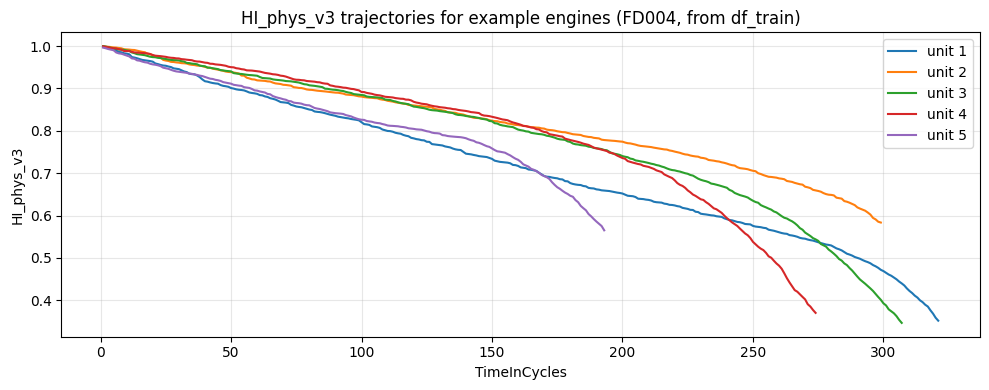

In [122]:
# 2) Trajektorienplots für einige Engines
if df_res is not None and "HI_phys_v3" in df_res.columns:
    unique_units = df_res[unit_col].unique()
    example_units_v3 = unique_units[:5]
    print("Example units for HI_phys_v3:", example_units_v3)

    plt.figure(figsize=(10, 4))
    for uid in example_units_v3:
        tmp = df_res[df_res[unit_col] == uid].sort_values(cycle_col)
        plt.plot(tmp[cycle_col], tmp["HI_phys_v3"], label=f"unit {uid}")

    plt.xlabel(cycle_col)
    plt.ylabel("HI_phys_v3")
    plt.title("HI_phys_v3 trajectories for example engines (FD004, from df_train)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("[INFO] Skipping HI_phys_v3 trajectory plot (df_res/HI_phys_v3 missing).")


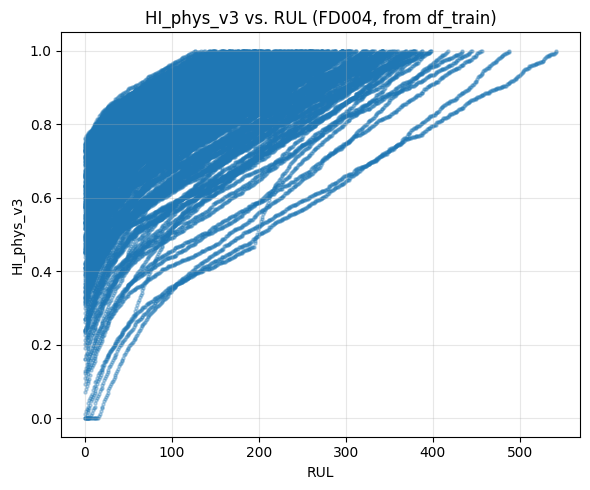

In [123]:
# 3) Optional: Scatter-Plot HI_phys_v3 vs. RUL (falls RUL verfügbar)
if df_res is not None and "HI_phys_v3" in df_res.columns and "RUL" in df_res.columns:
    df_corr = df_res.dropna(subset=["HI_phys_v3", "RUL"]).copy()
    plt.figure(figsize=(6, 5))
    plt.scatter(df_corr["RUL"], df_corr["HI_phys_v3"], s=5, alpha=0.3)
    plt.xlabel("RUL")
    plt.ylabel("HI_phys_v3")
    plt.title("HI_phys_v3 vs. RUL (FD004, from df_train)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("[INFO] Skipping HI_phys_v3 vs. RUL scatter (RUL or HI_phys_v3 missing in df_res).")


Number of engines with RUL == 0: 249
HI_phys_v3 at EOL – min=0.0000, max=0.7634, mean=0.5146


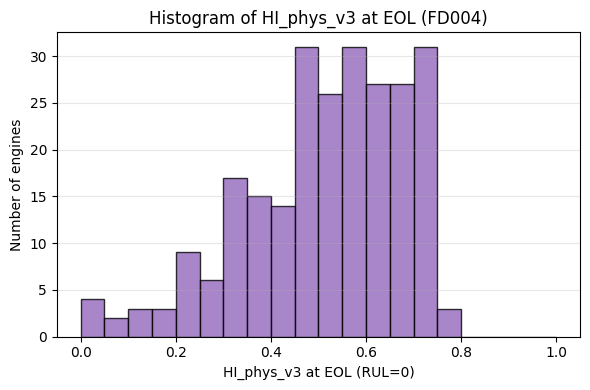

In [124]:
# 4) Histogramm von HI_phys_v3 am EOL (RUL == 0)

if df_res is not None and "HI_phys_v3" in df_res.columns and "RUL" in df_res.columns:
    # Pro Engine den letzten Punkt mit RUL == 0 auswählen (EOL)
    df_eol_candidates = df_res[df_res["RUL"] <= 0].copy()
    if df_eol_candidates.empty:
        print("[INFO] No rows with RUL == 0 found in df_res – cannot build EOL histogram.")
    else:
        df_eol = (
            df_eol_candidates
            .sort_values([unit_col, cycle_col])
            .groupby(unit_col, as_index=False)
            .tail(1)
        )
        hi_eol = df_eol["HI_phys_v3"].to_numpy()
        print(f"Number of engines with RUL == 0: {len(hi_eol)}")
        print(f"HI_phys_v3 at EOL – min={hi_eol.min():.4f}, max={hi_eol.max():.4f}, mean={hi_eol.mean():.4f}")

        plt.figure(figsize=(6, 4))
        plt.hist(hi_eol, bins=20, range=(0.0, 1.0), alpha=0.8, color="tab:purple", edgecolor="black")
        plt.xlabel("HI_phys_v3 at EOL (RUL=0)")
        plt.ylabel("Number of engines")
        plt.title("Histogram of HI_phys_v3 at EOL (FD004)")
        plt.grid(True, axis="y", alpha=0.3)
        plt.tight_layout()
        plt.show()
else:
    print("[INFO] Skipping EOL HI_phys_v3 histogram (df_res, HI_phys_v3 or RUL missing).")
